In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 28.1 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 86 kB 7.4 MB/s 
     |████████████████████████████████| 212 kB 74.7 MB/s 
     |████████████████████████████████| 140 kB 52.4 MB/s 
     |████████████████████████████████| 1.1 MB 53.4 MB/s 
     |████████████████████████████████| 596 kB 57.3 MB/s 
     |████████████████████████████████| 127 kB 74.3 MB/s 
     |████████████████████████████████| 144 kB 74.0 MB/s 
     |████████████████████████████████| 271 kB 77.4 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 77.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing in

In [2]:
from datasets import load_dataset, load_metric, Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelWithLMHead
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn import metrics
from scipy.special import softmax
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

**1**

In [5]:
main_data = pd.read_csv("main_data.csv")
pre_main_data = pd.read_csv("pre_main_data.csv")
main_data

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...
24778,25291,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,1,youu got wild bitches tellin you lies


In [6]:
pre_main_data

,id,label,tweet
0,0,2,! <user> as a woman you should not complain ab...
1,1,1,! <user> boy dats cold tyga dwn bad for cuffin...
2,2,1,! <user> dawg ! <user> you ever fuck a bitch a...
3,3,1,! <user> <user> she look like a tranny
4,4,1,! <user> the shit you hear about me might be t...
...,...,...,...
24428,25291,1,you a muthaf***in <censored> lie “ <user> <use...
24429,25292,2,you have gone and broke the wrong heart baby a...
24430,25294,1,young buck wanna eat ! dat nigguh like i aint ...
24431,25295,1,youu got wild bitches tellin you lies


**2**

In [7]:
dataset = Dataset.from_pandas(pre_main_data)
train_test = dataset.train_test_split(test_size=0.2)
train_valid = train_test['train'].train_test_split(test_size=0.1)
dataset = DatasetDict({'train': train_valid['train'], 'validation': train_valid['test'], 'test': train_test['test'],})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 17591
    })
    validation: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 1955
    })
    test: Dataset({
        features: ['id', 'label', 'tweet'],
        num_rows: 4887
    })
})

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(example):
  tokenized_batch = tokenizer(example["tweet"], truncation=True)
  return tokenized_batch

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(["id", "tweet"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

tokenized_datasets

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17591
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1955
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4887
    })
})

In [9]:
input_size = 768
hidden_dimension = 384
layers_number = 2
connected_size = 512
learning_rate = 5e-4
dropout = 0.1

class LSTM(torch.nn.Module):
  def __init__(self, input_size=input_size, num_classes=3):
    super().__init__()
    self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_dimension, num_layers=layers_number, bidirectional=True, batch_first=True).to(device)
    net_list = [torch.nn.Linear(input_size, connected_size), torch.nn.Tanh(), torch.nn.LayerNorm(connected_size), torch.nn.Dropout(dropout), torch.nn.Linear(connected_size, num_classes)]
    self.label_net = torch.nn.Sequential(*net_list).to(device)
    self.training_criterion = torch.nn.CrossEntropyLoss()
    self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=0)
    self.to(device)
    
  def forward(self, model_last_hidden_states):  
    x, _ = self.lstm(model_last_hidden_states)
    x = x[:, -1, :]  
    x = self.label_net(x)
    return x

In [10]:
class Trainer:
  def __init__(self, model, tokenized_datasets, seq_to_seq=False, input_size=input_size):
    self.model = model.to(device)
    self.tokenized_datasets = tokenized_datasets
    self.lstm_model = LSTM(input_size=input_size).to(device)
    self.seq_to_seq = seq_to_seq
    self.dataloaders = {}
    self.dataloaders["train"] = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator)
    self.history = {"loss": {"train": [], "validation": [], "test": []}, "accuracy": {"train": [], "validation": [], "test": []}}
    print(self.lstm_model)

  def plot_history(self):
      for metric in ["loss", "accuracy"]:
          loss_history = self.history[metric]
          plt.plot(loss_history["train"])
          plt.plot(loss_history["validation"])
          plt.title(f"{metric} history")
          plt.legend(['Train', 'Validation'])
          plt.show()
      print("TEST RESULTS:")
      print("Test Loss:    ", self.history["loss"]["test"][-1])
      print("Test Accuracy:", self.history["accuracy"]["test"][-1])
            
  def plot_cm(self, y_true, preds):
      cm = confusion_matrix(y_true, preds)
      plt.figure(figsize=(7, 5))
      ax = sns.heatmap(cm, annot=True, cmap='Blues')
      plt.title('Confusion Matrix')
      plt.ylabel('True Label')
      plt.xlabel('Predicted Label')
      plt.show() 

  def update_history(self, epoch, train_loss = None):
      for part in ["train", "validation", "test"]:
          loss, accuracy = self.loss_compute(self.tokenized_datasets[part], desc=f"{part} loss", print_metrics=part=="test")
          self.history["loss"][part].append(loss)
          self.history["accuracy"][part].append(accuracy)
      print(f"[Epoch {epoch + 1}] loss: {self.history['loss']['train'][-1]}, val_loss: {self.history['loss']['validation'][-1]}")
      

  def train(self, epochs=3):
      for epoch in tqdm(range(epochs)):
          model.eval()
          self.lstm_model.train()
          running_loss = 0.0
          steps = 0
          for batch in tqdm(self.dataloaders["train"]):
              batch = {k: v.to(device) for k, v in batch.items()}
              if self.seq_to_seq:
                  outputs = self.model(input_ids=batch["input_ids"], decoder_input_ids=batch["input_ids"], output_hidden_states=True)
                  encoder_hidden_states = torch.stack([val.detach() for val in outputs.encoder_hidden_states])
                  decoder_hidden_states = torch.stack([val.detach() for val in outputs.decoder_hidden_states])
                  last_hidden_states = decoder_hidden_states[-1].to(device)
              else:
                  outputs = self.model(**batch, output_hidden_states=True, return_dict=True)
                  hidden_states = torch.stack([val.detach() for val in outputs.hidden_states])  
                  last_hidden_states = hidden_states[-1].to(device)
              output = self.lstm_model(last_hidden_states)
              loss = self.lstm_model.training_criterion(output.to(device), torch.tensor(batch["labels"], dtype=torch.long))
              loss.backward()
              self.lstm_model.optimizer.step()
              self.lstm_model.optimizer.zero_grad()
              
              running_loss += loss.item()
              steps += 1
          self.update_history(epoch)
          self.plot_history()
              
  def loss_compute(self, tokenized_dataset, print_metrics=False, desc=""):
      dataloader = DataLoader(tokenized_dataset, batch_size=8, collate_fn=data_collator)
      self.lstm_model.eval()
      with torch.no_grad():
          running_loss = 0
          steps = 0
          preds = None
          for batch in tqdm(dataloader, desc=desc):
              batch = {k: v.to(device) for k, v in batch.items()}
              if self.seq_to_seq:
                  outputs = self.model(input_ids=batch["input_ids"], decoder_input_ids=batch["input_ids"], output_hidden_states=True)
                  encoder_hidden_states = torch.stack([val.detach() for val in outputs.encoder_hidden_states])
                  decoder_hidden_states = torch.stack([val.detach() for val in outputs.decoder_hidden_states])
                  last_hidden_states = decoder_hidden_states[-1].to(device)
              else:
                  outputs = self.model(**batch, output_hidden_states=True, return_dict=True)
                  hidden_states = torch.stack([val.detach() for val in outputs.hidden_states]) 
                  last_hidden_states = hidden_states[-1].to(device)
              output = self.lstm_model(last_hidden_states)
              preds = output if preds == None else torch.cat((preds, output), 0)
              loss = self.lstm_model.training_criterion(output.to(device), torch.tensor(batch["labels"].clone().detach(), dtype=torch.long))
              running_loss += loss.item()
              steps += 1
          preds = preds.cpu().argmax(-1)
      y_true = np.array(tokenized_dataset["labels"])
      accuracy = sklearn.metrics.accuracy_score(y_true, preds)
      report = classification_report(y_true, preds)
      if print_metrics:
          print(report)
          self.plot_cm(y_true, preds)
      return running_loss / steps, accuracy

LSTM(
  (lstm): LSTM(768, 384, num_layers=2, batch_first=True, bidirectional=True)
  (label_net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): Tanh()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (training_criterion): CrossEntropyLoss()
)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.88      0.98      0.93      3771
           2       0.85      0.72      0.78       817

    accuracy                           0.88      4887
   macro avg       0.58      0.57      0.57      4887
weighted avg       0.82      0.88      0.85      4887



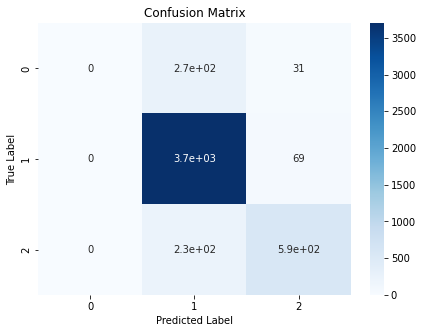

[Epoch 1] loss: 0.3174761439092955, val_loss: 0.3387060713859237


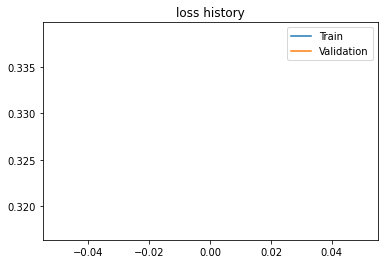

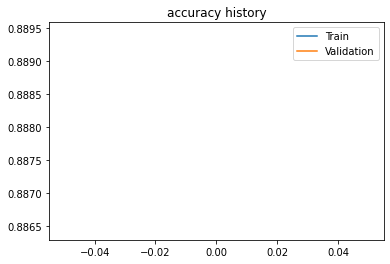

TEST RESULTS:
Test Loss:     0.36248856909274324
Test Accuracy: 0.8778391651319828


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       1.00      0.01      0.02       299
           1       0.90      0.97      0.93      3771
           2       0.83      0.80      0.81       817

    accuracy                           0.89      4887
   macro avg       0.91      0.59      0.59      4887
weighted avg       0.89      0.89      0.86      4887



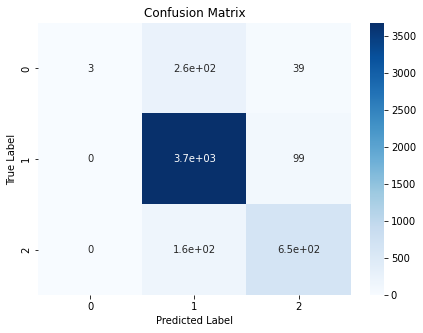

[Epoch 2] loss: 0.25845440818151866, val_loss: 0.2984739146518464


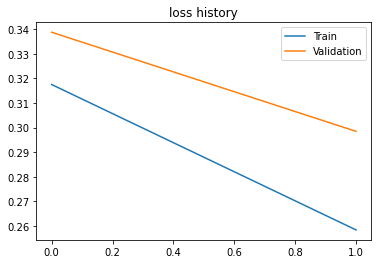

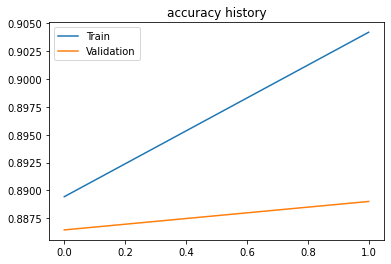

TEST RESULTS:
Test Loss:     0.31461668584599434
Test Accuracy: 0.8858195211786372


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.34      0.54      0.42       299
           1       0.92      0.92      0.92      3771
           2       0.89      0.69      0.78       817

    accuracy                           0.86      4887
   macro avg       0.72      0.72      0.71      4887
weighted avg       0.88      0.86      0.87      4887



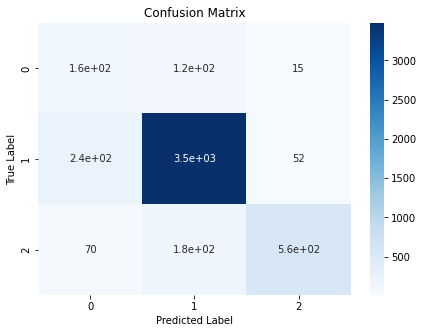

[Epoch 3] loss: 0.27525301785608514, val_loss: 0.32855347787619243


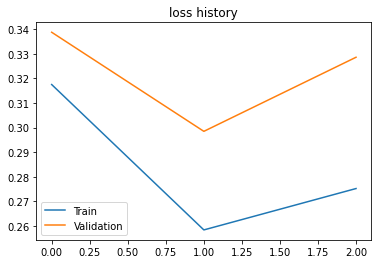

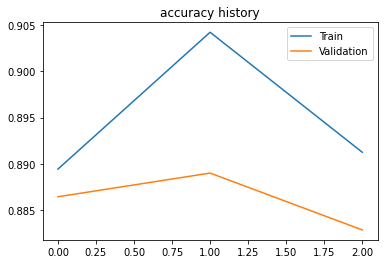

TEST RESULTS:
Test Loss:     0.3668143377256764
Test Accuracy: 0.8598322078985062


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.72      0.11      0.20       299
           1       0.92      0.97      0.94      3771
           2       0.82      0.86      0.84       817

    accuracy                           0.90      4887
   macro avg       0.82      0.65      0.66      4887
weighted avg       0.89      0.90      0.88      4887



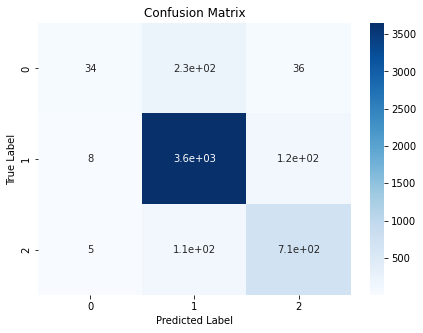

[Epoch 4] loss: 0.1903420963943794, val_loss: 0.28077974813819234


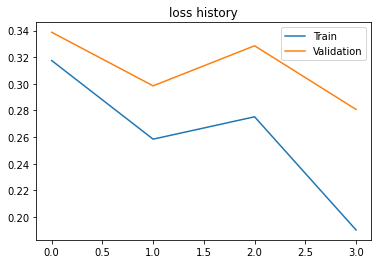

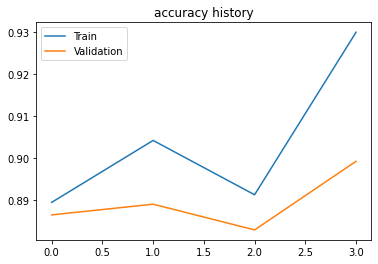

TEST RESULTS:
Test Loss:     0.3072180323327134
Test Accuracy: 0.8978923675056272


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.42      0.45      0.44       299
           1       0.93      0.94      0.93      3771
           2       0.85      0.82      0.83       817

    accuracy                           0.89      4887
   macro avg       0.74      0.74      0.74      4887
weighted avg       0.89      0.89      0.89      4887



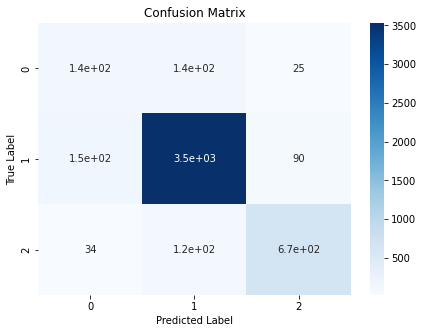

[Epoch 5] loss: 0.17001255062756457, val_loss: 0.2884390965959399


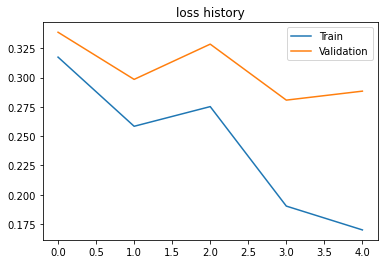

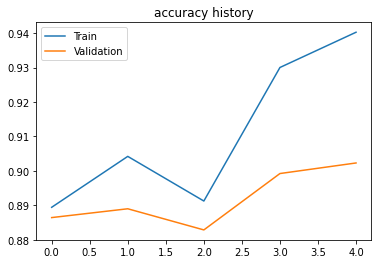

TEST RESULTS:
Test Loss:     0.3168650434097906
Test Accuracy: 0.8870472682627378


In [12]:
trainer = Trainer(model, tokenized_datasets)
trainer.train(epochs=5)

**3**

In [13]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(example):
    return tokenizer(example["tweet"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["id", "tweet"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained("GroNLP/hateBERT", num_labels=3)
model.to(device)

tokenized_datasets

Downloading:   0%|          | 0.00/151 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17591
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1955
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4887
    })
})

LSTM(
  (lstm): LSTM(768, 384, num_layers=2, batch_first=True, bidirectional=True)
  (label_net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): Tanh()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (training_criterion): CrossEntropyLoss()
)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.45      0.29      0.35       299
           1       0.92      0.95      0.93      3771
           2       0.83      0.84      0.83       817

    accuracy                           0.89      4887
   macro avg       0.73      0.69      0.71      4887
weighted avg       0.88      0.89      0.88      4887



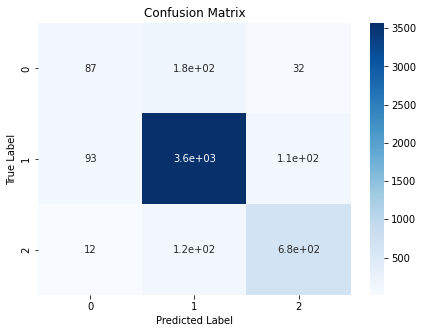

[Epoch 1] loss: 0.2569363487133923, val_loss: 0.2773758326904202


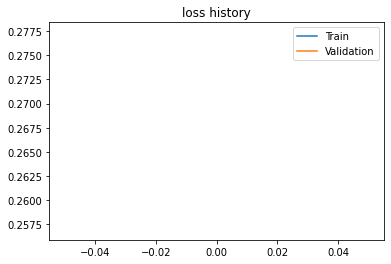

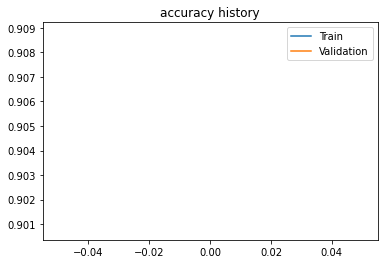

TEST RESULTS:
Test Loss:     0.31545800614474057
Test Accuracy: 0.8876611418047882


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.54      0.29      0.38       299
           1       0.94      0.94      0.94      3771
           2       0.81      0.91      0.86       817

    accuracy                           0.90      4887
   macro avg       0.76      0.72      0.73      4887
weighted avg       0.89      0.90      0.89      4887



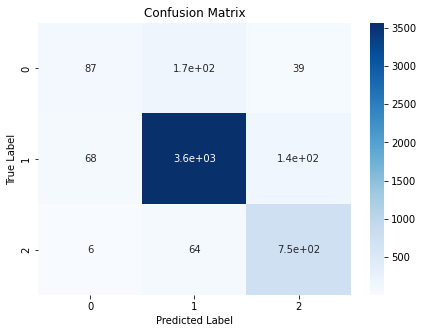

[Epoch 2] loss: 0.217163251414336, val_loss: 0.26278025116011194


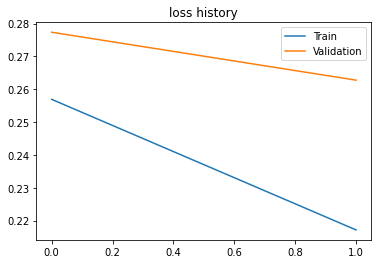

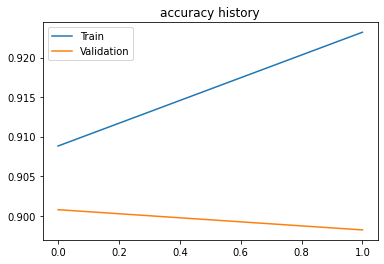

TEST RESULTS:
Test Loss:     0.29575929262122036
Test Accuracy: 0.8995293636177614


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.70      0.10      0.18       299
           1       0.90      0.98      0.94      3771
           2       0.88      0.79      0.83       817

    accuracy                           0.90      4887
   macro avg       0.83      0.62      0.65      4887
weighted avg       0.88      0.90      0.87      4887



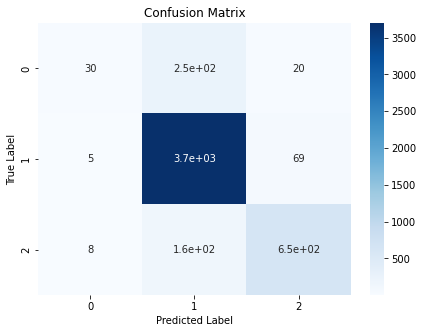

[Epoch 3] loss: 0.19368438778278682, val_loss: 0.28589535558273144


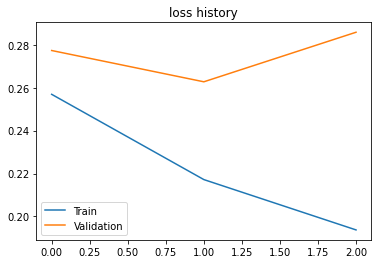

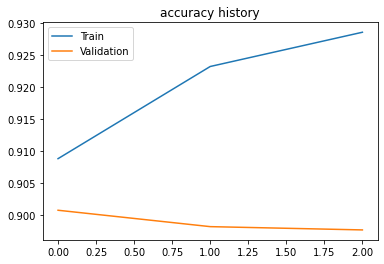

TEST RESULTS:
Test Loss:     0.3189974090274204
Test Accuracy: 0.895232248823409


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.79      0.05      0.09       299
           1       0.91      0.98      0.94      3771
           2       0.86      0.86      0.86       817

    accuracy                           0.90      4887
   macro avg       0.85      0.63      0.63      4887
weighted avg       0.89      0.90      0.88      4887



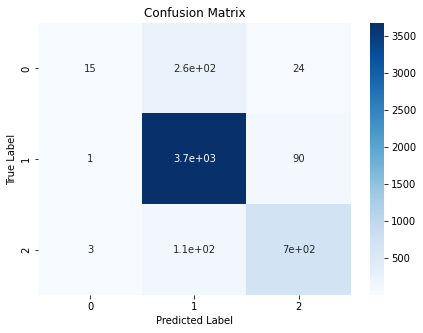

[Epoch 4] loss: 0.17652519995481344, val_loss: 0.2957149027789734


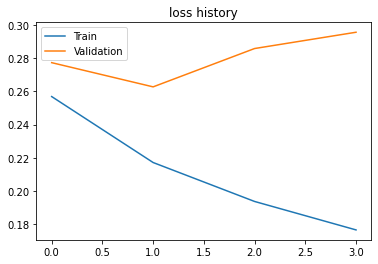

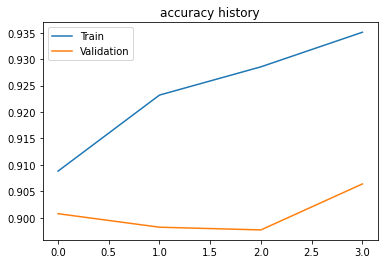

TEST RESULTS:
Test Loss:     0.3230356207245476
Test Accuracy: 0.8993247391037447


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.52      0.32      0.40       299
           1       0.93      0.96      0.94      3771
           2       0.85      0.84      0.84       817

    accuracy                           0.90      4887
   macro avg       0.76      0.71      0.73      4887
weighted avg       0.89      0.90      0.89      4887



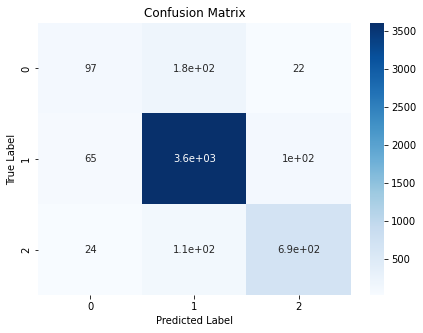

[Epoch 5] loss: 0.12243195737308893, val_loss: 0.2964440721163184


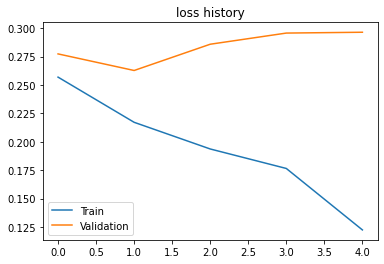

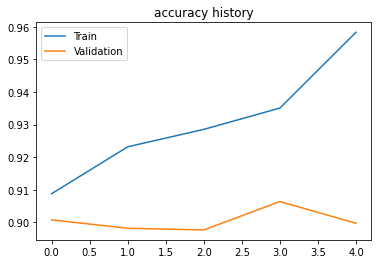

TEST RESULTS:
Test Loss:     0.3305050168306843
Test Accuracy: 0.8974831184775937


In [15]:
trainer = Trainer(model, tokenized_datasets)
trainer.train(epochs=5)

**5**

In [20]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(example):
    return tokenizer(example["tweet"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["id", "tweet"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

model = AutoModelWithLMHead.from_pretrained("t5-base", num_labels=3)
model.to(device)

tokenized_datasets

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:161: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 17591
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1955
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4887
    })
})

LSTM(
  (lstm): LSTM(768, 384, num_layers=2, batch_first=True, bidirectional=True)
  (label_net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): Tanh()
    (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
  (training_criterion): CrossEntropyLoss()
)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.87      0.96      0.92      3771
           2       0.70      0.63      0.66       817

    accuracy                           0.85      4887
   macro avg       0.53      0.53      0.53      4887
weighted avg       0.79      0.85      0.82      4887



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


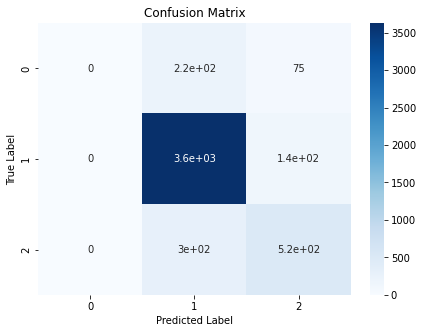

[Epoch 1] loss: 0.41273150976921763, val_loss: 0.411140285675623


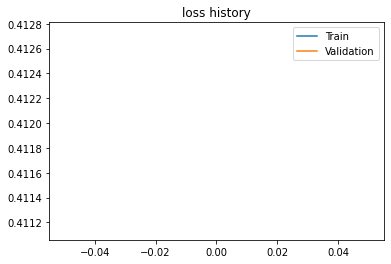

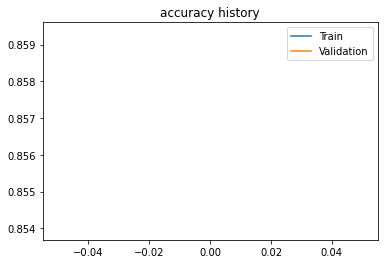

TEST RESULTS:
Test Loss:     0.43245206513547274
Test Accuracy: 0.8477593615715162


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.92      0.95      0.94      3771
           2       0.72      0.90      0.80       817

    accuracy                           0.88      4887
   macro avg       0.55      0.62      0.58      4887
weighted avg       0.83      0.88      0.86      4887



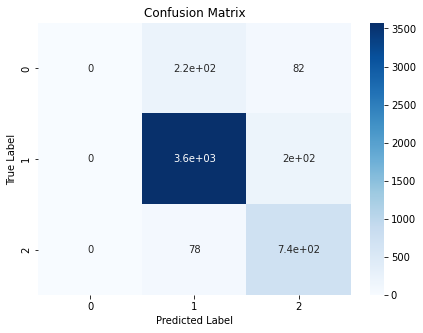

[Epoch 2] loss: 0.3320294626323119, val_loss: 0.3588407444710634


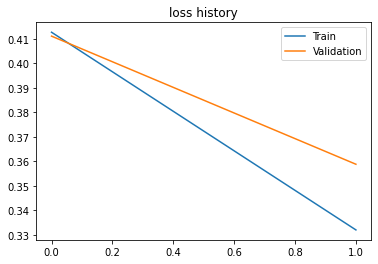

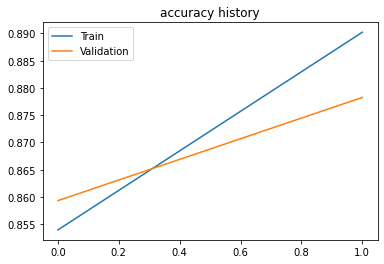

TEST RESULTS:
Test Loss:     0.3637061457952969
Test Accuracy: 0.8821362799263351


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.94      0.93      0.94      3771
           2       0.69      0.96      0.80       817

    accuracy                           0.88      4887
   macro avg       0.54      0.63      0.58      4887
weighted avg       0.84      0.88      0.86      4887



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


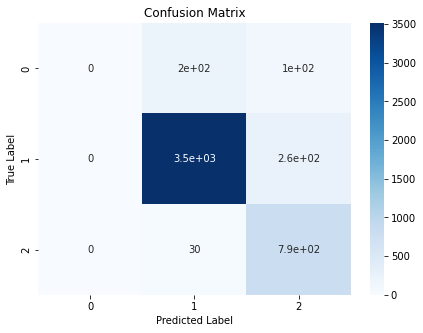

[Epoch 3] loss: 0.3341573784276064, val_loss: 0.34769517940526107


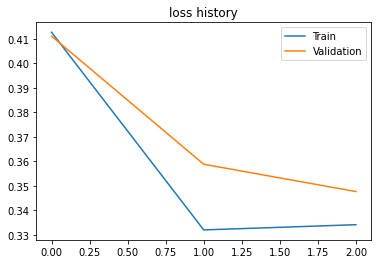

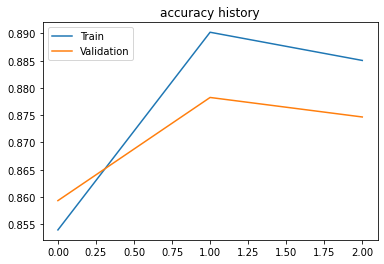

TEST RESULTS:
Test Loss:     0.3608261624902926
Test Accuracy: 0.8796807857581338


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.90      0.97      0.93      3771
           2       0.81      0.80      0.81       817

    accuracy                           0.88      4887
   macro avg       0.57      0.59      0.58      4887
weighted avg       0.83      0.88      0.86      4887



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


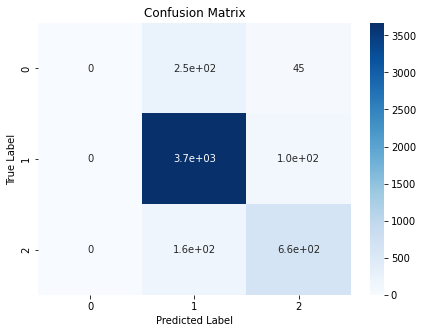

[Epoch 4] loss: 0.2784110459280101, val_loss: 0.31913862507410196


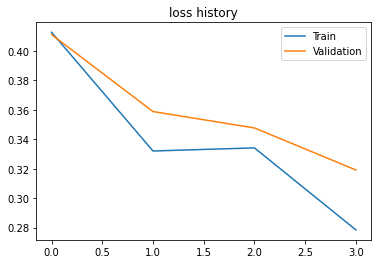

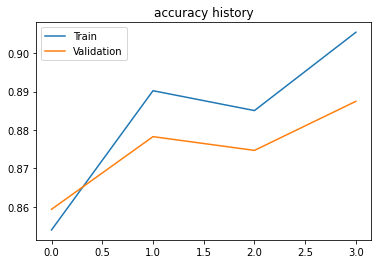

TEST RESULTS:
Test Loss:     0.34369348257219146
Test Accuracy: 0.8843871495805198


  0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train loss:   0%|          | 0/2199 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

validation loss:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and

test loss:   0%|          | 0/611 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       299
           1       0.92      0.96      0.94      3771
           2       0.78      0.89      0.84       817

    accuracy                           0.89      4887
   macro avg       0.57      0.62      0.59      4887
weighted avg       0.84      0.89      0.87      4887



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


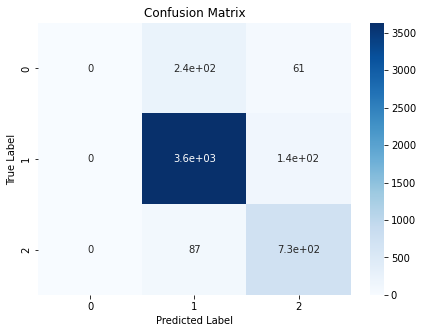

[Epoch 5] loss: 0.25427240754251945, val_loss: 0.31121009240040975


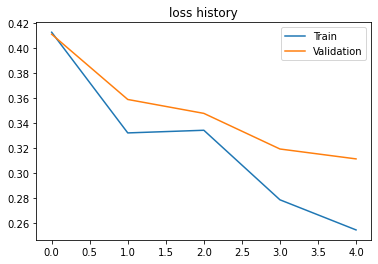

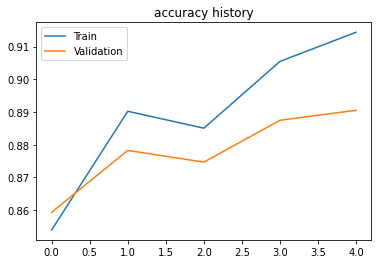

TEST RESULTS:
Test Loss:     0.3277132766787725
Test Accuracy: 0.892572130141191


In [21]:
trainer = Trainer(model, tokenized_datasets, seq_to_seq=True)
trainer.train(epochs=5)